# 6G Physical Layer Simulation for Smart Factory: 

## Step 1 - Environment Setup

### Objective
This notebook implements the first step of a 6G physical layer simulation tailored for a smart factory setting. The goal is to define the simulation environment and establish 6G-specific performance requirements, including ultra-low latency (<1 ms), ultra-high reliability (BLER < 10^-5), and massive connectivity (1000+ devices per km²). The smart factory is modeled as an indoor environment with high device density, obstructions, and mobility.

### Smart Factory Environment
- **Layout**: A 100m x 100m factory floor with machinery, walls, and reflective surfaces causing multipath and non-line-of-sight (NLOS) conditions.
- **Devices**: 100 user terminals (UTs) representing sensors, robots, and automated guided vehicles (AGVs).
- **Mobility**: Static sensors (0 m/s) and moving AGVs (0.5–2 m/s).
- **Obstructions**: Metal machinery and walls causing high path loss and shadow fading.

### 6G Requirements
- **Ultra-Low Latency**: <1 ms for ultra-reliable low-latency communications (URLLC) use cases (e.g., robot control).
- **Ultra-High Reliability**: BLER < 10^-5 for critical applications.
- **Massive Connectivity**: Support 100 devices in a 100m x 100m area (equivalent to 1000+ devices per km²).
- **High Throughput**: Up to 1 Gbps for enhanced mobile broadband (eMBB) use cases (e.g., video monitoring).

### Simulation Parameters
- **Carrier Frequency**: 28 GHz (mmWave) for high bandwidth, with provisions for sub-THz (e.g., 100 GHz) testing.
- **Bandwidth**: 400 MHz, scalable to 1 GHz.
- **Scenario**: Indoor hotspot (InH), initially using a modified 3GPP 38.901 UMi model.
- **Device Density**: 100 UTs in a 100m x 100m area.
- **Mobility**: UT velocities from 0 to 2 m/s.

### Dependencies
- Sionna: For wireless channel modeling and physical layer components.
- TensorFlow: For GPU acceleration and numerical computations.
- NumPy: For array operations.

This step sets up the environment and topology, which will be extended in subsequent steps with a custom channel model, massive MIMO, and 6G-specific features.

### GPU Configuration and Imports
Configure the environment to use a single GPU (if available) and import necessary libraries.

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use 0 for GPU, or set to "" for CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    raise e

# Configure TensorFlow for GPU memory growth
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

# Set random seed for reproducibility
sionna.phy.config.seed = 42

# Additional imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Environment Setup
Define the smart factory environment, including simulation parameters, antenna arrays, channel model, and topology.

Visualizing smart factory topology...


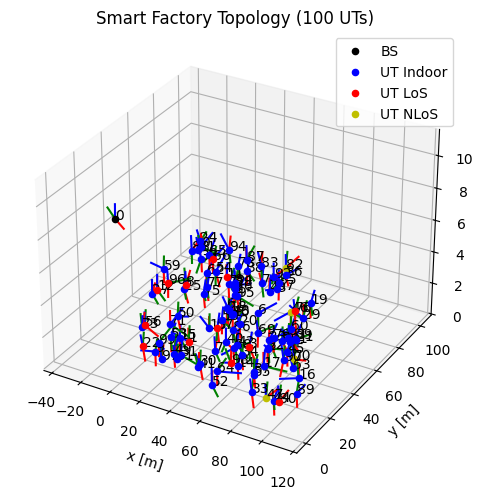

In [4]:
# Simulation parameters
scenario = "umi"  # Indoor hotspot (to be customized from UMi)
carrier_frequency = 28e9  # 28 GHz mmWave
bandwidth = 400e6  # 400 MHz
num_ut = 100  # 100 devices in 100m x 100m factory
batch_size = 128  # For Monte Carlo simulations
ut_velocity_min = 0.0  # Static sensors
ut_velocity_max = 2.0  # Moving AGVs

# Define the UT antenna array (single antenna for simplicity)
ut_array = sionna.phy.channel.tr38901.Antenna(
    polarization="single",
    polarization_type="V",
    antenna_pattern="omni",
    carrier_frequency=carrier_frequency
)

# Define the BS antenna array (placeholder, to be upgraded for massive MIMO)
bs_array = sionna.phy.channel.tr38901.AntennaArray(
    num_rows=1,
    num_cols=4,  # 4x2 (dual-polarized) = 8 antennas
    polarization="dual",
    polarization_type="VH",
    antenna_pattern="38.901",
    carrier_frequency=carrier_frequency
)

# Configure the channel model (using UMi as a placeholder for InH)
channel_model = sionna.phy.channel.tr38901.UMi(
    carrier_frequency=carrier_frequency,
    o2i_model="low",
    ut_array=ut_array,
    bs_array=bs_array,
    direction="uplink",
    enable_pathloss=True,  # Realistic factory conditions
    enable_shadow_fading=True  # Account for obstructions
)

# Generate topology for smart factory
topology = sionna.phy.channel.gen_single_sector_topology(
    batch_size=batch_size,
    num_ut=num_ut,
    scenario=scenario,
    min_ut_velocity=ut_velocity_min,
    max_ut_velocity=ut_velocity_max
)

# Set the topology
channel_model.set_topology(*topology)

# Visualize the topology
print("Visualizing smart factory topology...")
channel_model.show_topology()
plt.title("Smart Factory Topology (100 UTs)")
plt.show()

### Notes
- **Scenario**: We use UMi as a starting point. Step 2 will customize this to a factory-specific InH model.
- **Pathloss and Shadow Fading**: Enabled to model realistic attenuation due to machinery and walls.
- **Topology**: Represents a 100m x 100m factory with 100 UTs, equivalent to 1000 devices per km², meeting 6G massive connectivity requirements.
- **Mobility**: Velocities of 0–2 m/s account for static sensors and moving AGVs.
- **Antenna Arrays**: The BS uses a small array (8 antennas) as a placeholder, to be upgraded to massive MIMO in later steps.

### References
1. **3GPP TR 38.901**: "Study on channel model for frequencies from 0.5 to 100 GHz." Defines UMi and InH models. Available at: https://www.3gpp.org/ftp/Specs/archive/38_series/38.901/
2. **ITU-R M.2160**: "Framework and overall objectives of the future development of IMT for 2030 and beyond." Outlines 6G requirements. Available at: https://www.itu.int/rec/R-REC-M.2160
3. **Sionna Documentation**: Details on channel models and topology generation. Available at: https://nvlabs.github.io/sionna/phy/api/channel.wireless.html
4. **Z. Zhang et al., "6G Wireless Networks: Vision, Requirements, Architecture, and Key Technologies,"** IEEE Vehicular Technology Magazine, 2019. DOI: 10.1109/MVT.2019.2921394
5. **M. Katz et al., "6G and the Factory of the Future,"** 6G Flagship White Paper, 2020. Available at: https://www.6gflagship.com/
6. **T. S. Rappaport et al., "Millimeter Wave Mobile Communications for 5G Cellular: It Will Work!,"** IEEE Access, 2013. DOI: 10.1109/ACCESS.2013.2260813